In [3]:
import chromadb
from sentence_transformers import SentenceTransformer
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, END
from langgraph.graph.state import CompiledStateGraph
from typing import TypedDict, List, Dict, Any, Annotated, Sequence
from typing_extensions import TypedDict
import operator
import os
from IPython.display import display, Markdown

In [ ]:
# ===============================================
# State Definition
# ===============================================
class AgentState(TypedDict):
    """ໂຄງສ້າງ State ສໍາລັບ Agent"""
    messages: Annotated[Sequence[Any], operator.add]
    question: str
    context: str
    documents: List[Dict]
    answer: str
    need_more_info: bool

In [ ]:
# ===============================================
# RAG Agent Class
# ===============================================
class SingleAgentRAG:
    def __init__(self, collection_name: str):
        """
        Initialize Single-Agent RAG with LangGraph
        """
        # ໂຫຼດ ChromaDB client
        self.client = chromadb.PersistentClient(path="../Vector/chroma_db")
        
        # ໂຫຼດ embedding model
        self.embedding_model = SentenceTransformer('D:/model/BAAI-bge-m3', device='cpu')
        
        # ໂຫຼດ collection
        try:
            self.collection = self.client.get_collection(name=collection_name)
            print(f"✅ ໂຫຼດ collection ສໍາເລັດ: {collection_name}")
            print(f"   ມີເອກະສານທັງໝົດ: {self.collection.count()} ເອກະສານ")
        except Exception as e:
            print(f"❌ ບໍ່ສາມາດໂຫຼດ collection: {collection_name}")
            raise e
        
        # ຕິດຕັ້ງ Anthropic Claude
        api_key = os.getenv("ANTHROPIC_API_KEY")
        if not api_key:
            raise ValueError("ກະລຸນາໃຫ້ ANTHROPIC_API_KEY")
        
        self.llm = ChatAnthropic(
            api_key=api_key,
            model="claude-opus-4-1-20250805",
            temperature=0.0,
            max_tokens=2000
        )
        
        # ສ້າງ LangGraph workflow
        self.graph = self._build_graph()
    
    # ===============================================
    # Core Functions (Nodes)
    # ===============================================
    
    def retrieve_documents(self, state: AgentState) -> AgentState:
        """
        Node: ຄົ້ນຫາເອກະສານທີ່ກ່ຽວຂ້ອງຈາກ vector database
        """
        question = state["question"]
        print(f"🔍 ກໍາລັງຄົ້ນຫາເອກະສານສໍາລັບ: {question}")
        
        # Encode ແລະ ຄົ້ນຫາ
        query_embedding = self.embedding_model.encode([question]).tolist()
        
        results = self.collection.query(
            query_embeddings=query_embedding,
            n_results=10  # ເລີ່ມດ້ວຍ 10 documents
        )
        
        # ປະມວນຜົນເອກະສານ
        documents = []
        for i in range(len(results['documents'][0])):
            documents.append({
                'text': results['documents'][0][i],
                'score': 1 - results['distances'][0][i],
                'id': results['ids'][0][i]
            })
        
        # ສ້າງ context ຈາກເອກະສານທີ່ມີ score ສູງ
        context = "\n\n---\n\n".join([
            f"[Document {i+1} - Score: {doc['score']:.3f}]\n{doc['text']}" 
            for i, doc in enumerate(documents[:5])  # ໃຊ້ top 5 ສໍາລັບ context
        ])
        
        state["documents"] = documents
        state["context"] = context
        
        print(f"📄 ພົບເອກະສານ: {len(documents)} ເອກະສານ")
        return state
    
    def analyze_relevance(self, state: AgentState) -> AgentState:
        """
        Node: ວິເຄາະຄວາມກ່ຽວຂ້ອງຂອງເອກະສານ
        """
        print("🤔 ກໍາລັງວິເຄາະຄວາມກ່ຽວຂ້ອງ...")
        
        prompt = f"""ວິເຄາະວ່າເອກະສານເຫຼົ່ານີ້ມີຂໍ້ມູນພຽງພໍສໍາລັບຕອບຄໍາຖາມຫຼືບໍ່:

ຄໍາຖາມ: {state['question']}

ເອກະສານທີ່ພົບ:
{state['context']}

ຕອບດ້ວຍ:
1. SUFFICIENT - ຖ້າມີຂໍ້ມູນພຽງພໍ
2. INSUFFICIENT - ຖ້າຕ້ອງການຂໍ້ມູນເພີ່ມ

ເຫດຜົນ (1 ປະໂຫຍກ):"""

        response = self.llm.invoke(prompt)
        analysis = response.content.strip()
        
        # ກໍານົດວ່າຕ້ອງການຂໍ້ມູນເພີ່ມຫຼືບໍ່
        state["need_more_info"] = "INSUFFICIENT" in analysis.upper()
        
        if state["need_more_info"]:
            print("⚠️ ຕ້ອງການຂໍ້ມູນເພີ່ມເຕີມ")
        else:
            print("✅ ມີຂໍ້ມູນພຽງພໍ")
        
        return state
    
    def expand_search(self, state: AgentState) -> AgentState:
        """
        Node: ຂະຫຍາຍການຄົ້ນຫາຖ້າຕ້ອງການຂໍ້ມູນເພີ່ມ
        """
        print("🔄 ກໍາລັງຂະຫຍາຍການຄົ້ນຫາ...")
        
        # ສ້າງ query ໃໝ່ໂດຍໃຊ້ keywords
        prompt = f"""ສ້າງ 3 ຄໍາຄົ້ນຫາທີ່ແຕກຕ່າງກັນສໍາລັບຄໍາຖາມນີ້:
{state['question']}

ຕອບເປັນ format:
1. [keyword1]
2. [keyword2]  
3. [keyword3]"""

        response = self.llm.invoke(prompt)
        keywords = response.content.strip().split('\n')
        
        # ຄົ້ນຫາດ້ວຍແຕ່ລະ keyword
        all_docs = state["documents"]
        existing_ids = {doc['id'] for doc in all_docs}
        
        for keyword in keywords[:3]:
            keyword_clean = keyword.split('. ')[-1].strip('[]')
            query_embedding = self.embedding_model.encode([keyword_clean]).tolist()
            
            results = self.collection.query(
                query_embeddings=query_embedding,
                n_results=5
            )
            
            for i in range(len(results['documents'][0])):
                doc_id = results['ids'][0][i]
                if doc_id not in existing_ids:
                    all_docs.append({
                        'text': results['documents'][0][i],
                        'score': 1 - results['distances'][0][i],
                        'id': doc_id
                    })
                    existing_ids.add(doc_id)
        
        # ອັບເດດ context ດ້ວຍເອກະສານທັງໝົດ
        all_docs.sort(key=lambda x: x['score'], reverse=True)
        state["documents"] = all_docs[:15]  # ຈໍາກັດທີ່ 15 documents
        
        state["context"] = "\n\n---\n\n".join([
            f"[Document {i+1} - Score: {doc['score']:.3f}]\n{doc['text']}" 
            for i, doc in enumerate(state["documents"][:8])
        ])
        
        print(f"📚 ມີເອກະສານທັງໝົດ: {len(state['documents'])} ເອກະສານ")
        return state
    
    def generate_answer(self, state: AgentState) -> AgentState:
        """
        Node: ສ້າງຄໍາຕອບຈາກ context
        """
        print("💡 ກໍາລັງສ້າງຄໍາຕອບ...")
        
        prompt = f"""ທ່ານເປັນ AI Assistant ທີ່ຊ່ຽວຊານໃນການຕອບຄຳຖາມໂດຍອ້າງອີງຈາກເອກະສານ.

ຄຳແນະນຳ:
1. ຕອບຄຳຖາມໂດຍອ້າງອີງຈາກເອກະສານທີ່ໃຫ້ມາເທົ່ານັ້ນ
2. ຖ້າບໍ່ພົບຄຳຕອບໃນເອກະສານ, ໃຫ້ບອກວ່າບໍ່ພົບຂໍ້ມູນ
3. ລະບຸແຫຼ່ງຂໍ້ມູນທີ່ໃຊ້ (Document number)
4. ຕອບເປັນພາສາລາວ, ຊັດເຈນ ແລະ ລະອຽດ
5. ໃຊ້ Markdown format

ຂໍ້ມູນອ້າງອີງ:
{state['context']}

ຄໍາຖາມ: {state['question']}

ຄໍາຕອບ:"""

        response = self.llm.invoke(prompt)
        state["answer"] = response.content.strip()
        
        # ເພີ່ມ message ໃນ state
        state["messages"].append(HumanMessage(content=state['question']))
        state["messages"].append(AIMessage(content=state['answer']))
        
        return state
    
    def quality_check(self, state: AgentState) -> AgentState:
        """
        Node: ກວດສອບຄຸນນະພາບຄໍາຕອບ
        """
        print("✔️ ກໍາລັງກວດສອບຄຸນນະພາບ...")
        
        prompt = f"""ປະເມີນຄຸນນະພາບຂອງຄໍາຕອບນີ້:

ຄໍາຖາມ: {state['question']}
ຄໍາຕອບ: {state['answer']}

ປະເມີນ:
1. ຄໍາຕອບຕອບຄໍາຖາມໄດ້ຫຼືບໍ່? (ໄດ້/ບໍ່ໄດ້)
2. ມີແຫຼ່ງອ້າງອີງຫຼືບໍ່? (ມີ/ບໍ່ມີ)
3. ຄະແນນຄຸນນະພາບ (1-10):

ຖ້າຄະແນນຕໍ່າກວ່າ 7, ໃຫ້ຄໍາແນະນໍາການປັບປຸງ:"""

        response = self.llm.invoke(prompt)
        quality_assessment = response.content.strip()
        
        # ຖ້າຄຸນນະພາບຕໍ່າ, ເພີ່ມຄໍາແນະນໍາ
        if "ຄະແນນ" in quality_assessment:
            lines = quality_assessment.split('\n')
            for line in lines:
                if "ຄະແນນ" in line:
                    try:
                        score = int(''.join(filter(str.isdigit, line)))
                        if score < 7:
                            state["answer"] += f"\n\n---\n📝 **ໝາຍເຫດ:** ຄໍາຕອບນີ້ອາດບໍ່ຄົບຖ້ວນ. ກະລຸນາພິຈາລະນາຖາມຄໍາຖາມເພີ່ມເຕີມສໍາລັບຂໍ້ມູນລະອຽດ."
                    except:
                        pass
        
        return state
    
    # ===============================================
    # Conditional Edge Functions
    # ===============================================
    
    def should_expand_search(self, state: AgentState) -> str:
        """
        ຕັດສິນໃຈວ່າຄວນຂະຫຍາຍການຄົ້ນຫາຫຼືບໍ່
        """
        if state.get("need_more_info", False):
            return "expand"
        return "generate"
    
    # ===============================================
    # Build Graph
    # ===============================================
    
    def _build_graph(self) -> CompiledStateGraph:
        """
        ສ້າງ LangGraph workflow
        """
        # ສ້າງ StateGraph
        workflow = StateGraph(AgentState)
        
        # ເພີ່ມ nodes
        workflow.add_node("retrieve", self.retrieve_documents)
        workflow.add_node("analyze", self.analyze_relevance)
        workflow.add_node("expand_search", self.expand_search)
        workflow.add_node("generate", self.generate_answer)
        workflow.add_node("quality_check", self.quality_check)
        
        # ກໍານົດ flow
        workflow.set_entry_point("retrieve")
        workflow.add_edge("retrieve", "analyze")
        
        # Conditional edge ຈາກ analyze
        workflow.add_conditional_edges(
            "analyze",
            self.should_expand_search,
            {
                "expand": "expand_search",
                "generate": "generate"
            }
        )
        
        workflow.add_edge("expand_search", "generate")
        workflow.add_edge("generate", "quality_check")
        workflow.add_edge("quality_check", END)
        
        # Compile graph
        return workflow.compile()
    
    # ===============================================
    # Public Methods
    # ===============================================
    
    def ask(self, question: str) -> Dict[str, Any]:
        """
        ຖາມຄໍາຖາມ ແລະ ໄດ້ຮັບຄໍາຕອບ
        """
        # Initialize state
        initial_state = {
            "messages": [],
            "question": question,
            "context": "",
            "documents": [],
            "answer": "",
            "need_more_info": False
        }
        
        try:
            # Run the graph
            result = self.graph.invoke(initial_state)
            
            return {
                "question": question,
                "answer": result["answer"],
                "documents_used": len(result["documents"]),
                "sources": result["documents"][:5]  # Return top 5 sources
            }
        except Exception as e:
            return {
                "question": question,
                "answer": f"❌ ເກີດຂໍ້ຜິດພາດ: {str(e)}",
                "documents_used": 0,
                "sources": []
            }
    
    def visualize_graph(self):
        """
        ສະແດງໂຄງສ້າງຂອງ graph (ຕ້ອງມີ graphviz)
        """
        try:
            from IPython.display import Image, display
            display(Image(self.graph.get_graph().draw_mermaid_png()))
        except Exception as e:
            print(f"ບໍ່ສາມາດສະແດງ graph: {e}")
            print("Graph structure:")
            print("1. Retrieve Documents")
            print("2. Analyze Relevance")
            print("3. [Conditional] Expand Search (if needed)")
            print("4. Generate Answer")
            print("5. Quality Check")

In [ ]:
# ===============================================
# Main Function
# ===============================================

def main():
    """
    ຟັງຊັນຫຼັກສໍາລັບທົດສອບ
    """
    # Configuration
    COLLECTION_NAME = "pdf_documents"  # ປ່ຽນຕາມຊື່ collection ຂອງແຕ່ລະຄົນ
    
    try:
        # Initialize RAG Agent
        print("🚀 ກໍາລັງເລີ່ມລະບົບ Single-Agent RAG...")
        rag_agent = SingleAgentRAG(collection_name=COLLECTION_NAME)
        
        print("\n" + "="*50)
        print("💬 Single-Agent RAG System Ready!")
        print("="*50)
        
        # Optional: Visualize graph structure
        rag_agent.visualize_graph()
        
        # Interactive Q&A loop
        while True:
            question = input("\n❓ ຖາມຄໍາຖາມ (ຫຼື 'quit' ເພື່ອອອກ): ").strip()
            
            if question.lower() in ['quit', 'exit', 'ອອກ']:
                print("👋 ຂອບໃຈທີ່ໃຊ້ບໍລິການ!")
                break
            
            if question:
                print("\n" + "="*50)
                print("🤖 Agent ກໍາລັງປະມວນຜົນ...")
                print("="*50 + "\n")
                
                # Get answer
                result = rag_agent.ask(question)
                
                # Display results
                if isinstance(result, dict):
                    display(Markdown(f"## 💡 ຄໍາຕອບ:\n\n{result['answer']}"))
                    print(f"\n📊 ສະຖິຕິ:")
                    print(f"   - ເອກະສານທີ່ໃຊ້: {result['documents_used']}")
                    print(f"   - ແຫຼ່ງຂໍ້ມູນຫຼັກ: {len(result['sources'])} ແຫຼ່ງ")
                    
                    # Show top sources
                    if result['sources']:
                        print("\n📚 ແຫຼ່ງອ້າງອີງ:")
                        for i, source in enumerate(result['sources'][:3], 1):
                            print(f"   {i}. [Score: {source['score']:.3f}] {source['text'][:100]}...")
                else:
                    print(result)
                    
                print("\n" + "="*50)
    
    except Exception as e:
        print(f"❌ ເກີດຂໍ້ຜິດພາດ: {e}")  

🚀 ກໍາລັງເລີ່ມລະບົບ Single-Agent RAG...
✅ ໂຫຼດ collection ສໍາເລັດ: pdf_documents
   ມີເອກະສານທັງໝົດ: 95 ເອກະສານ

💬 Single-Agent RAG System Ready!


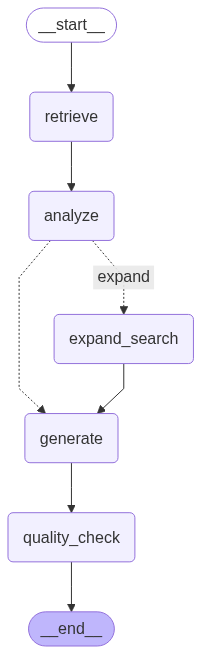


🤖 Agent ກໍາລັງປະມວນຜົນ...

🔍 ກໍາລັງຄົ້ນຫາເອກະສານສໍາລັບ: fixed loan ແມ່ນຍັງ
📄 ພົບເອກະສານ: 10 ເອກະສານ
🤔 ກໍາລັງວິເຄາະຄວາມກ່ຽວຂ້ອງ...
✅ ມີຂໍ້ມູນພຽງພໍ
💡 ກໍາລັງສ້າງຄໍາຕອບ...
✔️ ກໍາລັງກວດສອບຄຸນນະພາບ...


## 💡 ຄໍາຕອບ:

ອີງຕາມເອກະສານທີ່ໃຫ້ມາ (Document 2), **ເງິນກູ້ຄົງທີ່ (Fixed Loan)** ແມ່ນຜະລິດຕະພັນສິນເຊື່ອຂອງ ທຄຕລ ທີ່ມີຄຸນລັກສະນະດັ່ງນີ້:

## ຄຸນລັກສະນະຫຼັກ:
- ໃຊ້ສຳລັບ**ລົງທຶນຄົງທີ່** ເຊັ່ນ:
  - ກໍ່ສ້າງໂຮງງານ
  - ອາຄານ
  - ໂຮງແຮມ
  - ຊື້ເຄື່ອງຈັກ
  - ໂຄງການໄລຍະຍາວອື່ນໆ
- ສາມາດນຳໃຊ້ເປັນ**ທຶນໝູນວຽນ**ສຳລັບໂຄງການ ຫຼື ໄລຍະຍາວ

## ລັກສະນະສຳຄັນ:
Fixed Loan ແມ່ນເງິນກູ້ທີ່ມີຈຳນວນເງິນຄົງທີ່ ແລະ ມີການຊຳລະຄືນແບບແບ່ງງວດຕາມກຳນົດເວລາທີ່ຕົກລົງກັນ ເໝາະສຳລັບການລົງທຶນໃນຊັບສິນຄົງທີ່ ຫຼື ໂຄງການທີ່ຕ້ອງການເງິນທຶນຈຳນວນແນ່ນອນ.

**ແຫຼ່ງຂໍ້ມູນ:** Document 2


📊 ສະຖິຕິ:
   - ເອກະສານທີ່ໃຊ້: 10
   - ແຫຼ່ງຂໍ້ມູນຫຼັກ: 5 ແຫຼ່ງ

📚 ແຫຼ່ງອ້າງອີງ:
   1. [Score: 0.080] ປື້ມສັງລວມຜະລິດຕະພັນທັງໝົດຂອງ ທຄຕລ_2020_Update.2 ໜ�າທີ 67 
9.8 ໜັງສືຄ�້າປະກັນແບບ Standby Letter of C...
   2. [Score: 0.041] ປື້ມສັງລວມຜະລິດຕະພັນທັງໝົດຂອງ ທຄຕລ_2020_Update.2 ໜ�າທີ 51 
 
ຂ�້ມູນເພີ່ມຕື່ມ 
 ທ�ານທີ່ສົນໃຈຂ�້ມູນເພ...
   3. [Score: 0.034] ປື້ມສັງລວມຜະລິດຕະພັນທັງໝົດຂອງ ທຄຕລ_2020_Update.2 ໜ�າທີ 46 
10 ຈ�າຍຄ�າ ໂທລະສັບ ເບີ
ຕື່ມເງິນ 
1. ບ�ລິສ...


🤖 Agent ກໍາລັງປະມວນຜົນ...

🔍 ກໍາລັງຄົ້ນຫາເອກະສານສໍາລັບ: Package SMS Banking ສະໝັກແນວໃດ
📄 ພົບເອກະສານ: 10 ເອກະສານ
🤔 ກໍາລັງວິເຄາະຄວາມກ່ຽວຂ້ອງ...
⚠️ ຕ້ອງການຂໍ້ມູນເພີ່ມເຕີມ
🔄 ກໍາລັງຂະຫຍາຍການຄົ້ນຫາ...
📚 ມີເອກະສານທັງໝົດ: 11 ເອກະສານ
💡 ກໍາລັງສ້າງຄໍາຕອບ...
✔️ ກໍາລັງກວດສອບຄຸນນະພາບ...


## 💡 ຄໍາຕອບ:

ອີງຕາມເອກະສານທີ່ໃຫ້ມາ, ການສະໝັກ SMS Banking ມີຂັ້ນຕອນດັ່ງນີ້:

## ວິທີການສະໝັກ SMS Banking

### ຊ່ອງທາງການສະໝັກ
ທ່ານສາມາດສະໝັກແລະປະກອບແບບຟອມໄດ້ທີ່:

1. **ສະຖານທີ່:**
   - ສຳນັກງານໃຫຍ່ ທຄຕລ
   - ໜ່ວຍບໍລິການ ທຄຕລ
   - ສາຂາຂອງ ທຄຕລ

2. **ດາວໂຫຼດແບບຟອມ:**
   - ເວັບໄຊ້: http://www.bcel.com.la
   - ອີເມວ: e-banking@bcel.com.la
   - ສາຍດ່ວນໂທ: 1555

### ເງື່ອນໄຂການໃຊ້ບໍລິການ
- ທ່ານຕ້ອງມີບັນຊີເງິນຝາກປະຢັດ ຫຼື ບັນຊີເງິນຝາກກະແສລາຍວັນຢູ່ ທຄຕລ
- ທ່ານຕ້ອງເປັນເຈົ້າຂອງທີ່ມີສິດສັ່ງຈ່າຍຫຼືໄດ້ຮັບການມອບສິດຈາກເຈົ້າຂອງບັນຊີ
- ຍອມຮັບເງື່ອນໄຂ ແລະ ຂໍ້ກຳນົດໃນການໃຊ້ບໍລິການ

### ເອກະສານປະກອບ
- ແບບຟອມຂໍນຳໃຊ້ບໍລິການຂອງທະນາຄານ
- ສຳເນົາບັດປະຈຳຕົວຂອງເຈົ້າຂອງບັນຊີ
- ໃບມອບສິດ (ກໍລະນີມອບສິດໃຫ້ຜູ້ອື່ນ)
- ສຳເນົາບັດປະຈຳຕົວຂອງຜູ້ມອບສິດ ແລະຜູ້ຖືກມອບສິດ (ຖ້າມີການມອບສິດ)

**ໝາຍເຫດ:** ສຳເນົາເອກະສານທັງໝົດຕ້ອງບໍ່ໝົດອາຍຸ

*ແຫຼ່ງຂໍ້ມູນ: Document 1, Document 2*


📊 ສະຖິຕິ:
   - ເອກະສານທີ່ໃຊ້: 11
   - ແຫຼ່ງຂໍ້ມູນຫຼັກ: 5 ແຫຼ່ງ

📚 ແຫຼ່ງອ້າງອີງ:
   1. [Score: 0.178] ປື້ມສັງລວມຜະລິດຕະພັນທັງໝົດຂອງ ທຄຕລ_2020_Update.2 ໜ�າທີ 14 
 ຈັດການວົງເງິນໃນການໂອນ 
limits management...
   2. [Score: 0.170] ປື້ມສັງລວມຜະລິດຕະພັນທັງໝົດຂອງ ທຄຕລ_2020_Update.2 ໜ�າທີ 16 
ຟອມລົງທະບຽນ 
 ທ�ານສາມາດສະໝັກແລະປະກອບແບບຟ...
   3. [Score: 0.112] ປື້ມສັງລວມຜະລິດຕະພັນທັງໝົດຂອງ ທຄຕລ_2020_Update.2 ໜ�າທີ 49 
 ທະນາຄານຈະບ�່ໃຫ�ບ�ລິການສົ່ງເງິນ  MoneyGr...


🤖 Agent ກໍາລັງປະມວນຜົນ...

🔍 ກໍາລັງຄົ້ນຫາເອກະສານສໍາລັບ: ວິທີສະໝັກ Package ເດ້ລະ
📄 ພົບເອກະສານ: 10 ເອກະສານ
🤔 ກໍາລັງວິເຄາະຄວາມກ່ຽວຂ້ອງ...
⚠️ ຕ້ອງການຂໍ້ມູນເພີ່ມເຕີມ
🔄 ກໍາລັງຂະຫຍາຍການຄົ້ນຫາ...
📚 ມີເອກະສານທັງໝົດ: 14 ເອກະສານ
💡 ກໍາລັງສ້າງຄໍາຕອບ...
✔️ ກໍາລັງກວດສອບຄຸນນະພາບ...


## 💡 ຄໍາຕອບ:

ອີງຕາມເອກະສານທີ່ໃຫ້ມາ, ຂ້ອຍບໍ່ພົບຂໍ້ມູນກ່ຽວກັບ "Package ເດ້ລະ" ໂດຍສະເພາະ.

ແຕ່ມີຂໍ້ມູນກ່ຽວກັບການສະໝັກ Package ສໍາລັບບໍລິການ SMS Banking ດັ່ງນີ້:

## ວິທີສະໝັກ Package SMS Banking:

**ຂັ້ນຕອນການສະໝັກ:**
- ພິມ **B10** [ຍະຫວ່າງ] **<ເລກບັນຊີ>** ແລ້ວສົ່ງໄປເບີ **1444**

**Package ທີ່ມີໃຫ້ເລືອກ:**

| ລະຫັດ Package | ຈໍານວນເງິນ (ກີບ) | ໄລຍະເວລາໃຊ້ງານ | ຈໍານວນຂໍ້ຄວາມ |
|--------------|-----------------|----------------|--------------|
| B05 | 5,000 | 365 ວັນ | 30 ຂໍ້ຄວາມ |
| B10 | 10,000 | 365 ວັນ | 60 ຂໍ້ຄວາມ |
| B25 | 25,000 | 365 ວັນ | 150 ຂໍ້ຄວາມ |
| B50 | 50,000 | 365 ວັນ | 300 ຂໍ້ຄວາມ |
| B100 | 100,000 | 365 ວັນ | 600 ຂໍ້ຄວາມ |

**ໝາຍເຫດ:** ຖ້າທ່ານຕ້ອງການຂໍ້ມູນກ່ຽວກັບ Package ອື່ນໆ ທີ່ບໍ່ແມ່ນ SMS Banking, ກະລຸນາລະບຸໃຫ້ຊັດເຈນກວ່ານີ້.

*ແຫຼ່ງຂໍ້ມູນ: Document 8*


📊 ສະຖິຕິ:
   - ເອກະສານທີ່ໃຊ້: 14
   - ແຫຼ່ງຂໍ້ມູນຫຼັກ: 5 ແຫຼ່ງ

📚 ແຫຼ່ງອ້າງອີງ:
   1. [Score: 0.061] ປື້ມສັງລວມຜະລິດຕະພັນທັງໝົດຂອງ ທຄຕລ_2020_Update.2 ໜ�າທີ 85 
 ແມ�ນບັດເດບິດແບບຕື່ມເງິນລູກຄ�າຕ�ອງຕື່ມເງ...
   2. [Score: 0.030] ປື້ມສັງລວມຜະລິດຕະພັນທັງໝົດຂອງ ທຄຕລ_2020_Update.2 ໜ�າທີ 16 
ຟອມລົງທະບຽນ 
 ທ�ານສາມາດສະໝັກແລະປະກອບແບບຟ...
   3. [Score: 0.009] ປື້ມສັງລວມຜະລິດຕະພັນທັງໝົດຂອງ ທຄຕລ_2020_Update.2 ໜ�າທີ 80 
  
5. ລະບົບຈະສະແດງຂ�້ມູນບັດສະມາຊິກຂອງທ�ານ...


🤖 Agent ກໍາລັງປະມວນຜົນ...

🔍 ກໍາລັງຄົ້ນຫາເອກະສານສໍາລັບ: WeChat Pay ຄ່າທຳນຽມເທົ່າໃດ
📄 ພົບເອກະສານ: 10 ເອກະສານ
🤔 ກໍາລັງວິເຄາະຄວາມກ່ຽວຂ້ອງ...
⚠️ ຕ້ອງການຂໍ້ມູນເພີ່ມເຕີມ
🔄 ກໍາລັງຂະຫຍາຍການຄົ້ນຫາ...
📚 ມີເອກະສານທັງໝົດ: 15 ເອກະສານ
💡 ກໍາລັງສ້າງຄໍາຕອບ...
✔️ ກໍາລັງກວດສອບຄຸນນະພາບ...


## 💡 ຄໍາຕອບ:

ອີງຕາມເອກະສານທີ່ໃຫ້ມາ, **WeChat Pay ມີຄ່າທຳນຽມ 2.5% ຕໍ່ລາຍການ**.

ຂໍ້ມູນນີ້ມາຈາກ:
- **Document 5** - ໜ້າທີ 16 ຂອງປື້ມສັງລວມຜະລິດຕະພັນທັງໝົດຂອງ ທຄຕລ

WeChat Pay ເປັນບໍລິການທີ່ສາມາດຮັບຊຳລະສິນຄ້າ ແລະ ບໍລິການໄດ້ຈາກກຸ່ມລູກຄ້າຄົນຈີນ ຫຼື ບັນດາປະເທດທີ່ສາມາດນຳໃຊ້ Application ດັ່ງກ່າວໃນການຊຳລະ, ເໝາະສົມກັບປະເພດທຸລະກິດທີ່ໃຫ້ບໍລິການ ແລະ ຈຳໜ່າຍສິນຄ້າໃຫ້ກຸ່ມລູກຄ້າທີ່ເປັນຄົນຈີນ.


📊 ສະຖິຕິ:
   - ເອກະສານທີ່ໃຊ້: 15
   - ແຫຼ່ງຂໍ້ມູນຫຼັກ: 5 ແຫຼ່ງ

📚 ແຫຼ່ງອ້າງອີງ:
   1. [Score: 0.119] ປື້ມສັງລວມຜະລິດຕະພັນທັງໝົດຂອງ ທຄຕລ_2020_Update.2 ໜ�າທີ 50 
ເງື່ອນໄຂການໃຊ�
ບ�ລິການ 
 
 ກະກຽມເອກະສານ ...
   2. [Score: 0.091] ປື້ມສັງລວມຜະລິດຕະພັນທັງໝົດຂອງ ທຄຕລ_2020_Update.2 ໜ�າທີ 85 
 ແມ�ນບັດເດບິດແບບຕື່ມເງິນລູກຄ�າຕ�ອງຕື່ມເງ...
   3. [Score: 0.086] ປື້ມສັງລວມຜະລິດຕະພັນທັງໝົດຂອງ ທຄຕລ_2020_Update.2 ໜ�າທີ 87 
ຄ�າທ�ານຽມໂອນເງິນຈາກບັດໜຶ່ງໄປບັດອື່ນ ບ�່ເກ...

👋 ຂອບໃຈທີ່ໃຊ້ບໍລິການ!


In [4]:
if __name__ == "__main__":
    main()